# Predição do **churn**

Este é o arquivo principal que roda todo a pipeline para a predição do **churn** utilizando o dataset em "*Abandono_clientes.csv*" para treinamento e o dataset de teste deve possuir a mesma estrutura do arquivo "*Abandono_teste.csv*" para funcionar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from prediction_models.svm import svm_model
from prediction_models.logistic_regression import lr_model
from prediction_models.neural_network import nn_model
from prediction_models.random_forest import rf_model
from prediction_models.sgpc import sgpc_model
from prediction_models.gradient_boost import gb_model

In [3]:
def drop_irrelevant(df):
    df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
    df = df.dropna()  # drop missing values
    return df

def encode_categorical(df):
    df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
    df = pd.get_dummies(df, columns=['Geography'], drop_first=False)
    return df

The problem here is a binary classification problem, where a client may have *Exited* (1) or not (0).

If the problem is too simple, a logistic regression can be performed. However, neural networks have come into play and they can achieve the same of a logistic regression and even more, like solving nonlinear problems through nonlinear activation functions and appropriate amount of neurons and hidden layers. Therefore, it is advantageous to start with more advanced machine learning models, due to the fact that many variables appear to be affecting **churn** and their relationships are not yet known.

The **churn** prediction using the "*Abandono_clientes.csv*" data will be performed with different models down below. A validation set will be separated to test the accuracy of the model and to stop the training avoiding overfitting. The performance will be measured using the rate of true positives and true negatives.

Also, a Gaussian Process can provide uncertainty estimation at the expense of computational cost.

Random forests, Support Vector Machine, can also work.

#### 1. Load dataset

In [9]:
df_test = pd.read_csv('Abandono_teste.csv', delimiter=';')
df_original = pd.read_csv('Abandono_clientes.csv')

##### 1.1. Preprocess data

In [11]:
df = drop_irrelevant(df_original)
df = encode_categorical(df)

df_test = drop_irrelevant(df_test)
df_test = encode_categorical(df_test)

X_test = df_test.values

#### 2. Split dataset

In [12]:
X = df.drop('Exited', axis=1).values  # Features
y = df['Exited'].values               # Target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### 3. Normalize data

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### 4. Testing different ML models

In [14]:
all_results = dict()

##### 4.1. Logistic regression

In [15]:
results = lr_model(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled)

# Access the results
val_accuracy = results["validation_accuracy"]
test_predictions = results["test_predictions"]

all_results['lr_model'] = {'val_acc': val_accuracy, 'test_preds': test_predictions}

Validation Accuracy: 0.8110


##### 4.2. Random forest

In [16]:
results, model = rf_model(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled)

# Access the results
val_accuracy = results["validation_accuracy"]
test_predictions = results["test_predictions"]

all_results['rf_model'] = {'val_acc': val_accuracy, 'test_preds': test_predictions}

Validation Accuracy: 0.8660


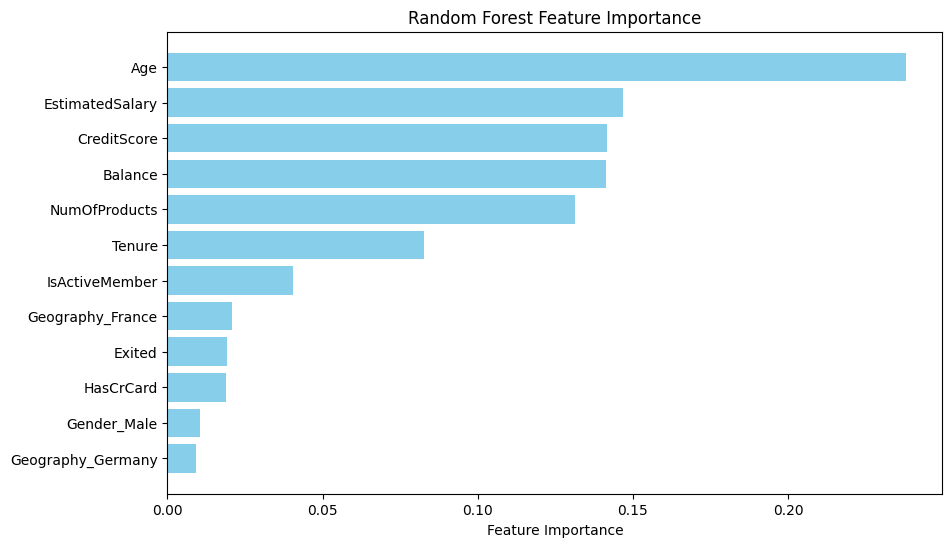

In [17]:
feature_importances = model.feature_importances_
    
# Plot feature importance
feature_names = list(df.columns)
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

##### 4.3. Gradient boosting classifier

In [18]:
results, model = gb_model(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled)

# Access the results
val_accuracy = results["validation_accuracy"]
test_predictions = results["test_predictions"]

all_results['gb_model'] = {'val_acc': val_accuracy, 'test_preds': test_predictions}

Validation Accuracy: 0.8650


4.3.1. Investigate the importance of each feature with the Gradient Boosting classifier

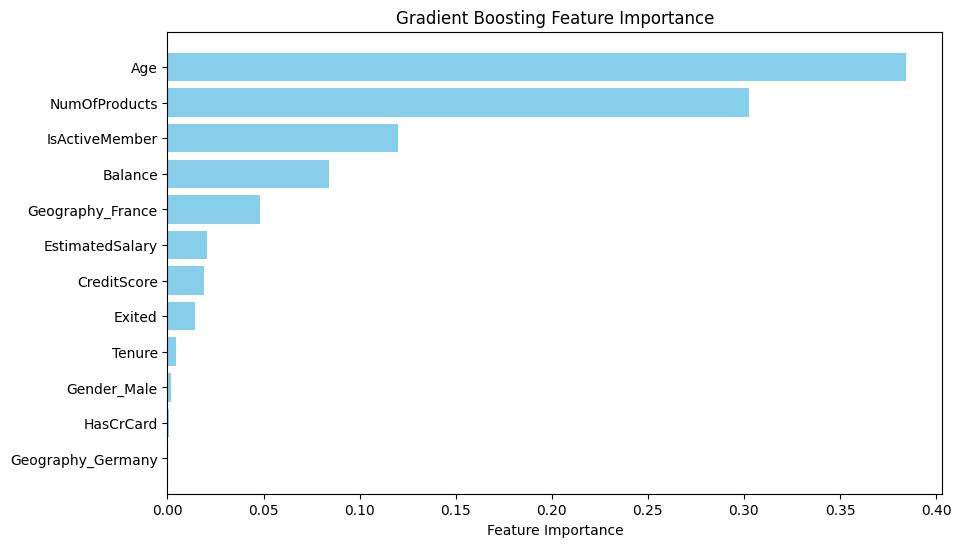

In [19]:
# Get feature importance from the model
feature_importances = model.feature_importances_
feature_names = list(df.columns)

# Sort features by importance
sorted_idx = np.argsort(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.show()


##### Support Vector Machine

In [20]:
results = svm_model(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled)

# Access the results
val_accuracy = results["validation_accuracy"]
test_predictions = results["test_predictions"]

all_results['svm_model'] = {'val_acc': val_accuracy, 'test_preds': test_predictions}

Validation Accuracy: 0.8560

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1607
           1       0.77      0.38      0.51       393

    accuracy                           0.86      2000
   macro avg       0.82      0.68      0.71      2000
weighted avg       0.85      0.86      0.84      2000


Confusion Matrix:
[[1562   45]
 [ 243  150]]


##### Sparse Gaussian process classification

In [21]:
results = sgpc_model(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled)

# Access the results
val_accuracy = results["validation_accuracy"]
test_predictions = results["test_predictions"]

# Print uncertainty
print(f'Predicted churn: {test_predictions.sum()}')
print(f'GP Churn uncertainty (95% confidence interval): [{results["uncertainty"][0]}, {results["uncertainty"][1]}]')

all_results['sgpc_model'] = {'val_acc': val_accuracy, 'test_preds': test_predictions}

Iteration 50/600 - Loss: 0.6246
Iteration 100/600 - Loss: 0.4289
Iteration 150/600 - Loss: 0.3974
Iteration 200/600 - Loss: 0.3865
Iteration 250/600 - Loss: 0.3807
Iteration 300/600 - Loss: 0.3771
Iteration 350/600 - Loss: 0.3745
Iteration 400/600 - Loss: 0.3726
Iteration 450/600 - Loss: 0.3712
Iteration 500/600 - Loss: 0.3700
Iteration 550/600 - Loss: 0.3691
Iteration 600/600 - Loss: 0.3683
Predictive uncertainty:
Max churn: 174.0 
Predicted churn: 124.0
Min churn: 85.0
Predicted churn: 124.0
GP Churn uncertainty (95% confidence interval): [85.0, 174.0]


##### Neural networks

In [22]:
results = nn_model(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled)

# Access the results
val_accuracy = results["validation_accuracy"]
test_predictions = results["test_predictions"]

all_results['nn_model'] = {'val_acc': val_accuracy, 'test_preds': test_predictions}

Epoch 1/50, Loss: 0.5030, Validation Accuracy: 0.8165
Epoch 2/50, Loss: 0.4230, Validation Accuracy: 0.8250
Epoch 3/50, Loss: 0.4022, Validation Accuracy: 0.8385
Epoch 4/50, Loss: 0.3710, Validation Accuracy: 0.8520
Epoch 5/50, Loss: 0.3505, Validation Accuracy: 0.8580
Epoch 6/50, Loss: 0.3437, Validation Accuracy: 0.8560
Epoch 7/50, Loss: 0.3380, Validation Accuracy: 0.8595
Epoch 8/50, Loss: 0.3354, Validation Accuracy: 0.8540
Epoch 9/50, Loss: 0.3332, Validation Accuracy: 0.8615
Epoch 10/50, Loss: 0.3306, Validation Accuracy: 0.8580
Epoch 11/50, Loss: 0.3294, Validation Accuracy: 0.8585
Epoch 12/50, Loss: 0.3266, Validation Accuracy: 0.8580
Epoch 13/50, Loss: 0.3247, Validation Accuracy: 0.8555
Epoch 14/50, Loss: 0.3245, Validation Accuracy: 0.8620
Epoch 15/50, Loss: 0.3223, Validation Accuracy: 0.8585
Epoch 16/50, Loss: 0.3207, Validation Accuracy: 0.8595
Epoch 17/50, Loss: 0.3184, Validation Accuracy: 0.8640
Epoch 18/50, Loss: 0.3168, Validation Accuracy: 0.8640
Epoch 19/50, Loss: 

#### 5. Check the results of all models

In [23]:
best_val_acc = -1.0
best = ''
for i in all_results:
    val_acc = all_results[i]['val_acc']
    print(f'{i}: {all_results[i]['val_acc']}')
    if val_acc > best_val_acc:
        best = i
        best_val_acc = val_acc

print(f'Best is --> {best}, with {best_val_acc*100:.4f}% accuracy')

lr_model: 0.811
rf_model: 0.866
gb_model: 0.865
svm_model: 0.856
sgpc_model: 0.859
nn_model: 0.8615
Best is --> rf_model, with 86.6000% accuracy
